In [32]:
import matplotlib.pyplot as plt
import numpy as np
from hsdfmpm.hsdfm.utils import find_cycles, gabor_filter_bank, leastsq_reflectance, mask_by_k_clustering, mask_by_gmm
from hsdfmpm.utils import apply_kernel_bank
from hsdfmpm.hsdfm import HyperspectralImage, MergedHyperspectralImage
from matplotlib.gridspec import GridSpec
import cv2
from photon_canon.contrib.bio import wl, eps


In [33]:
# Find raw data
cycles = find_cycles(r'E:\new df\POC Study\Animals')
wavelengths = np.arange(500, 610, 10)
# Load normalization data
standard = MergedHyperspectralImage(image_paths=find_cycles(r'E:\new df\POC Study\Standards\standard_080_unpolarized04252025'), scalar=0.8, wavelengths=wavelengths)
standard.normalize()
background = MergedHyperspectralImage(image_paths=find_cycles(r'E:\new df\POC Study\Background\dark_04282025'), wavelengths=wavelengths)
background.normalize()

[None, None, None]

In [34]:
# Load data and normalize
hs = HyperspectralImage(image_path=r'E:\new df\POC Study\Animals\1676NT\04252025\100\fov3\unpolarized_hyperspectral_cycle_0', standard_path=standard, background_path=background, wavelengths=wavelengths)
hs.normalize()
hs.bin(bin_factor=2048//256)

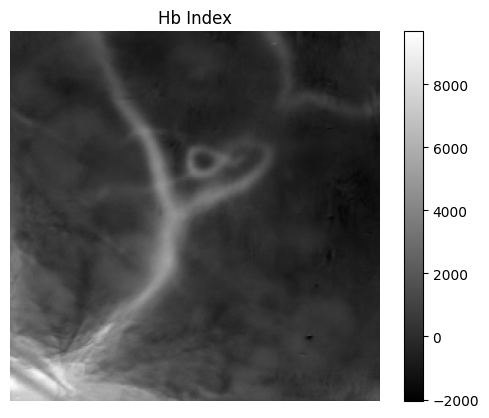

In [35]:
# Get variables for naive fit
selected = np.isin(wl, hs.metadata['Wavelength'])
e = np.log(10) * eps[:, selected] / 64500

# Fit the image with naive lsq and apply gabor bank
naive_fit = leastsq_reflectance(hs.image, e)
hb_index = naive_fit[0] + naive_fit[1]
plt.imshow(hb_index)
plt.title('Hb Index')
plt.axis('off')
plt.colorbar()
plt.show()

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

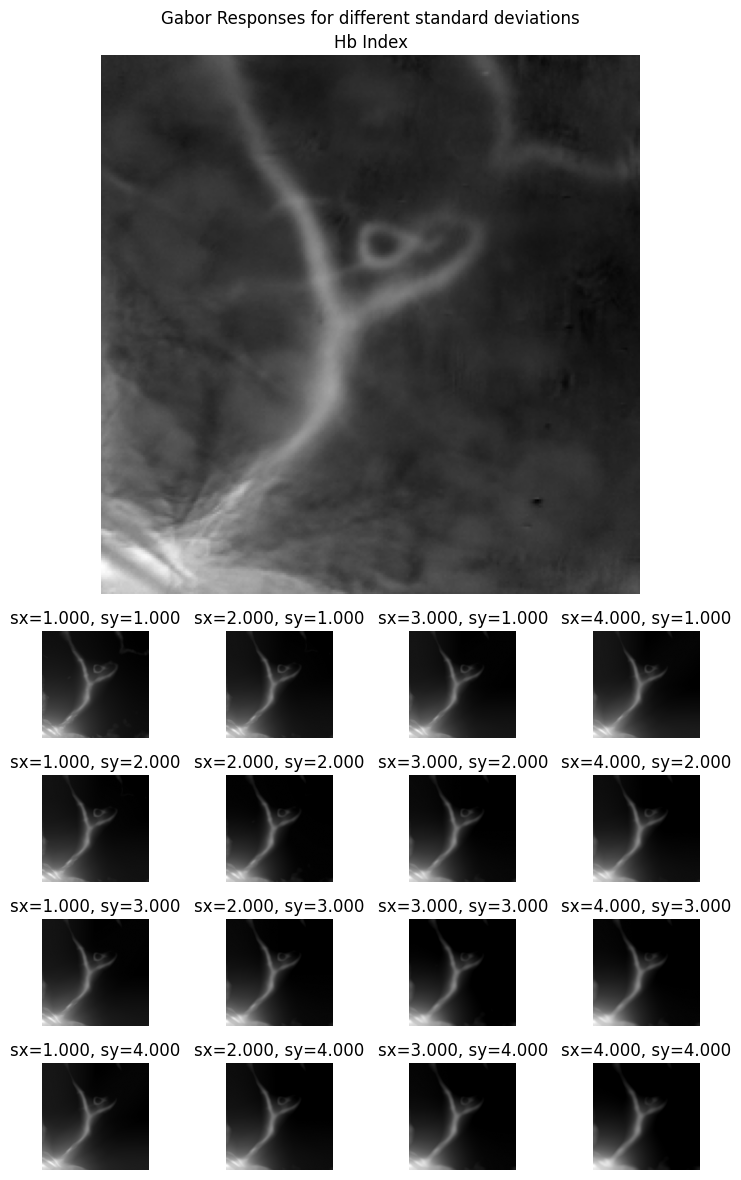

In [36]:
# Compare filter banks
f = np.geomspace(0.01, 1, 16)
fig = plt.figure(figsize=(7.5, 12))
gs = GridSpec(8, 4)
ax = fig.add_subplot(gs[:4, :4])
ax.imshow(hb_index)
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Hb Index')
fig.suptitle('Gabor Responses for different standard deviations')
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(gs[4 + j, i])
        gabor_bank = gabor_filter_bank(frequency=f, sigma_x=(i+1)/f, sigma_y=(j+1)/f)
        gabor_response = apply_kernel_bank(hb_index, gabor_bank)
        ax.set_title(f'sx={(i+1):.3f}, sy={(j+1):.3f}')
        ax.imshow(gabor_response)
        ax.axis('off')
        ax.set_aspect('equal')
plt.tight_layout()
plt.show()

  0%|          | 0/192 [00:00<?, ?it/s]

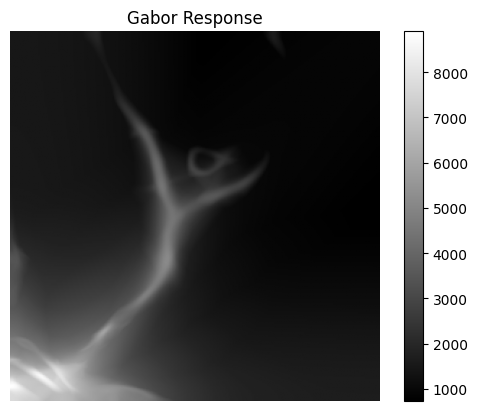

In [43]:
# Apply chosen Gabor design
gabor_response = apply_kernel_bank(hb_index, gabor_filter_bank(frequency=f, sigma_x=4/f, sigma_y=1/f))
plt.imshow(gabor_response)
plt.title('Gabor Response')
plt.axis('off')
plt.colorbar()
plt.show()

index 6 is out of bounds for axis 0 with size 6
index 6 is out of bounds for axis 0 with size 6


<Figure size 640x480 with 0 Axes>

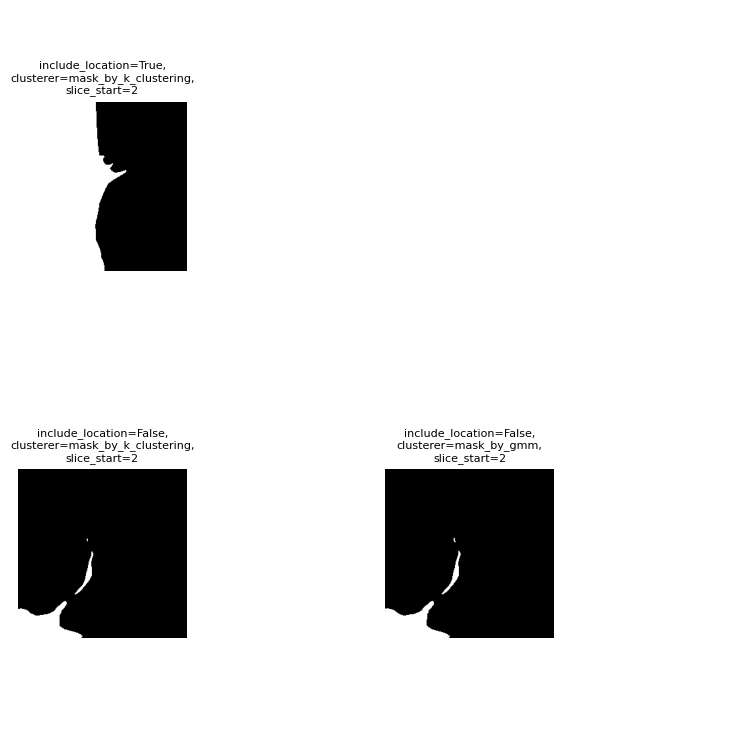

In [39]:
# Apply mask
plt.set_cmap('gray')
fig, axes = plt.subplots(2, 4, figsize=(7.5, 7.5))
for a in axes.flatten():
    a.axis('off')
for i, include_location in enumerate([True, False]):
    for j, clusterer in enumerate([mask_by_k_clustering, mask_by_gmm]):
        for k, slice_start in enumerate([1, 2]):
            try:
                ax = axes[i, (2 * j)]
                mask = clusterer(gabor_response, ks=[2, 3, 4, 5, 6, 7], include_location=include_location, slice_to_take=slice(slice_start, None, None))
                ax.imshow(mask)
                ax.set_title(f'include_location={include_location},\nclusterer={clusterer.__name__},\nslice_start={slice_start}', fontsize=8)
            except Exception as e:
                print(e)
                continue

plt.tight_layout()
plt.show()

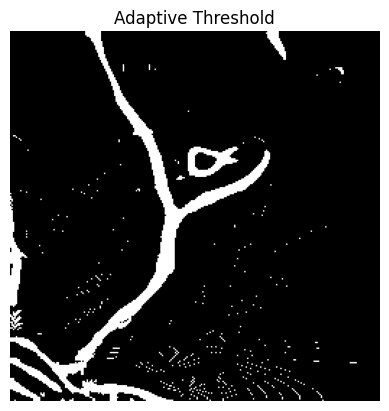

In [46]:
mask = cv2.adaptiveThreshold((gabor_response / gabor_response.max() * 255).astype(np.uint8), 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
plt.imshow(mask)
plt.axis('off')
plt.title('Adaptive Threshold')
plt.show()

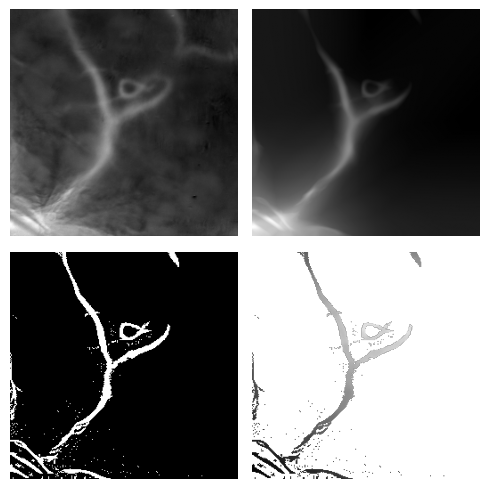

In [41]:
# Apply conditional masking
mask = np.logical_and(
    cv2.adaptiveThreshold((255 * gabor_response / gabor_response.max()).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 0).astype(bool),
    (gabor_response > 1000).astype(bool)
)
mask = mask.astype(bool)
hs.apply_mask(mask)
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for a in ax.flatten():
    a.axis('off')
ax[0, 0].imshow(hb_index)
ax[0, 1].imshow(gabor_response)
ax[1, 0].imshow(mask)
ax[1, 1].imshow(np.mean(hs.image, axis=0))
plt.tight_layout()
plt.show()